In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten

import tensorflow_addons as tfa
import cv2
import os 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error
import random 
import math
import time
import pandas as pd

import warnings 
warnings.filterwarnings(action='ignore')

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

AUTOTUNE = tf.data.AUTOTUNE

In [37]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
N_RES = 256 
N_BATCH = 128
PATH = 'C:/Users/user/Desktop/datasets/Child Skin Disease'
# PATH = '../../datasets/Child Skin Disease'
dataset_path = os.path.join(PATH, 'Total_Dataset')

# Train & test set
min_num = 100
max_num = 300 
base_num = 1000 

name_dict = {
    'Depressed scar' : 'Acne scar', 
    'Acquired tufted hemangioma' : 'Acquired tufted angioma', 
    'Cyst' : 'Epidermal cyst', 
    'Infantile hemangioma' : 'Hemangioma',
    'ILVEN': 'Inflammatory linear verrucous epidermal nevus'
}




In [4]:
def label_2_index(lbl, label_dict):
    return label_dict[lbl]

def index_2_label(idx, label_dict):
    key = [keys for keys in label_dict if (label_dict[keys] == idx)]
    return key

def train_generator(images, labels, aug=False):
    
    for img, lbl in zip(images, labels):
    
        img = img[0].decode('utf-8')
        img = cv2.imread(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_RES, N_RES))
        # img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

        yield (img, lbl)    
        
        # if lower than base num, should apply data augmentation
        # if base_num <= int(train_dict[idx]):
        if aug:
            # Btight 
            random_bright_tensor = tf.image.random_brightness(img, max_delta=128)
            random_bright_tensor = tf.clip_by_value(random_bright_tensor, 0, 255)
            random_bright_image = tf.keras.preprocessing.image.array_to_img(random_bright_tensor)
            yield (random_bright_tensor, lbl) 
    
            # rotation
            rotated_img = tf.image.rot90(img)        
            yield (rotated_img, lbl) 
            
            # # curmix 
            # cutmixed_img, cutmixed_lbl = cutmix(img, lbl)
            # yield (cutmixed_img, cutmixed_lbl)
            
                
def test_generator(images, labels):
    
    for img, lbl in zip(images, labels):
        
        img = img[0].decode('utf-8')
        
        img = cv2.imread(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_RES, N_RES))
        # img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

        yield (img, lbl)    
            
def create_dataset(images, labels, d_type='train', aug=False):
    
    if d_type == 'test':
        return tf.data.Dataset.from_generator(test_generator, 
                                              output_types=(tf.float64, tf.float32), 
                                              output_shapes=(tf.TensorShape([N_RES, N_RES, 3]), tf.TensorShape([1])),
                                              args=[images, labels])
        
    else:
        return tf.data.Dataset.from_generator(train_generator, 
                                              output_types=(tf.float64, tf.float32), 
                                              output_shapes=(tf.TensorShape([N_RES, N_RES, 3]), tf.TensorShape([1])),
                                              args=[images, labels, aug])
        
def create_all_dict(dataset, min_num, max_num):
    all_dict = dict() 
    count_all_dict = dict() 

    for i in range(10):
        files = os.listdir(os.path.join(dataset_path, f'H{i}'))
        
        for f in files:
            # imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
            imgs = glob(f'{dataset_path}/H{i}/{f}/*.jpg')
            
            # print(f)

            # class 통합 관련 내용 변경
            if f in name_dict: 
                f = name_dict[f]
            
            if f not in count_all_dict:
                count_all_dict[f] = len(imgs) 
            else:
                count_all_dict[f] += len(imgs)

    new_count_dict = count_all_dict.copy()

    # print(new_count_dict)

    # 데이터 정제
    for key, val in count_all_dict.items():
        if val < min_num:
            del new_count_dict[key]

        if val > max_num:
            new_count_dict[key] = max_num
            

    idx_num = 0 
    for key, val in new_count_dict.items():
        # print(idx)
        all_dict[key] = idx_num 
        idx_num += 1 
        
        
    return all_dict, new_count_dict

        
def create_train_list(dataset, all_dict, count_all_dict):
    images = []
    for i in range(6):

        for key, val in all_dict.items():
            img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
            images.extend(img)

        for key, val in name_dict.items():
            img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
            images.extend(img)

        
    # 전남대 추가
    for key, val in all_dict.items(): 
        img = glob(dataset + '/H9/{key}/*.jpg')
        images.extend(img) 

    for key, val in name_dict.items():
        img = glob(dataset + f'/H9/{key}/*.jpg')
        images.extend(img)

    # 고른 데이터 분배를 위한 random shuffle
    random.shuffle(images)

    # max 데이터 처리
    # count 를 돌면서 count
    # count_all_dict = all_dict.copy() 

    train_images = []
    for idx_imgs, val_imgs in enumerate(images):

        # class 통합 관련 내용 변경
        classes = val_imgs.split('/')[-1].split('\\')[0]
        # classes = val_imgs.split('/')[-2]
        
        
        if classes in name_dict:
            if count_all_dict[name_dict[classes]] > 0:
                count_all_dict[name_dict[classes]] -= 1
                train_images.append(val_imgs)

            else:
                continue

        else:
            if count_all_dict[classes] > 0:
                count_all_dict[classes] -= 1
                train_images.append(val_imgs)
            else:
                continue


    train_labels = [] 
    for img in train_images:
        lbl = img.split('/')[-1].split('\\')[0]
        # lbl = img.split('/')[-2]

        # 변경/통합 버전으로 label 처리
        if lbl in name_dict:
            lbl = name_dict[lbl]

        lbl = label_2_index(lbl, all_dict)
        train_labels.append(lbl)
        
    train_images = np.reshape(train_images, [-1, 1])
    train_labels = np.reshape(train_labels, [-1, 1])
    
    
    return train_images, train_labels
    

def get_dropout(input_tensor, p=0.3, mc=False):
    if mc: 
        layer = Dropout(p, name='top_dropout')
        return layer(input_tensor, training=True)
    else:
        return Dropout(p, name='top_dropout')(input_tensor, training=False)

In [5]:
def create_model(model_name, res=256, trainable=False, num_trainable=100, num_classes=10, mc=False): 

    # strategy = tf.distribute.MirroredStrategy()

    # with strategy.scope():

    if model_name == 'efficient':
        base_model = keras.applications.EfficientNetB4(include_top=False, input_shape=(res, res, 3),  weights = 'imagenet')
        base_model.trainable = trainable
        
        if trainable:
            for layer in base_model.layers[:num_trainable]:
                layer.trainable = False
        
        # print("Number of layers in the base model: ", len(base_model.layers))
        
        inputs = keras.Input(shape=(res, res, 3))
        x = base_model(inputs)
        x = keras.layers.GlobalAveragePooling2D()(x) 
        
        # add 20220714
        x = keras.layers.BatchNormalization()(x)
        
        x = get_dropout(x, mc)
        
        # add 20220714
        # x = keras.layers.Dense(512, activation='relu')(x)
        # x = keras.layers.Dense(256, activation='relu')(x)
        
        x = keras.layers.Dense(num_classes, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        
    # elif model_name == 'mobilenet':
        
        
    # VGG16 
    else:
        base_model = keras.applications.VGG16(include_top=False, input_shape=(res, res, 3),  weights = 'imagenet')
        base_model.trainable = trainable
        
        inputs = keras.Input(shape=(res, res, 3))
        x = base_model(inputs)
        x = keras.layers.Flatten(name = "avg_pool")(x) 
        x = keras.layers.Dense(512, activation='relu')(x)
        x = get_dropout(x, mc)
        x = keras.layers.Dense(256, activation='relu')(x)
        x = keras.layers.Dense(num_classes, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)

    model.compile(loss='sparse_categorical_crossentropy',
    # optimizer=tf.keras.optimizers.Adam(1e-2),
    optimizer='RMSprop', 
    metrics=['accuracy'])

    return model 


3
5
7
9
11
13
15
17
19
21
23
25
27
29
31


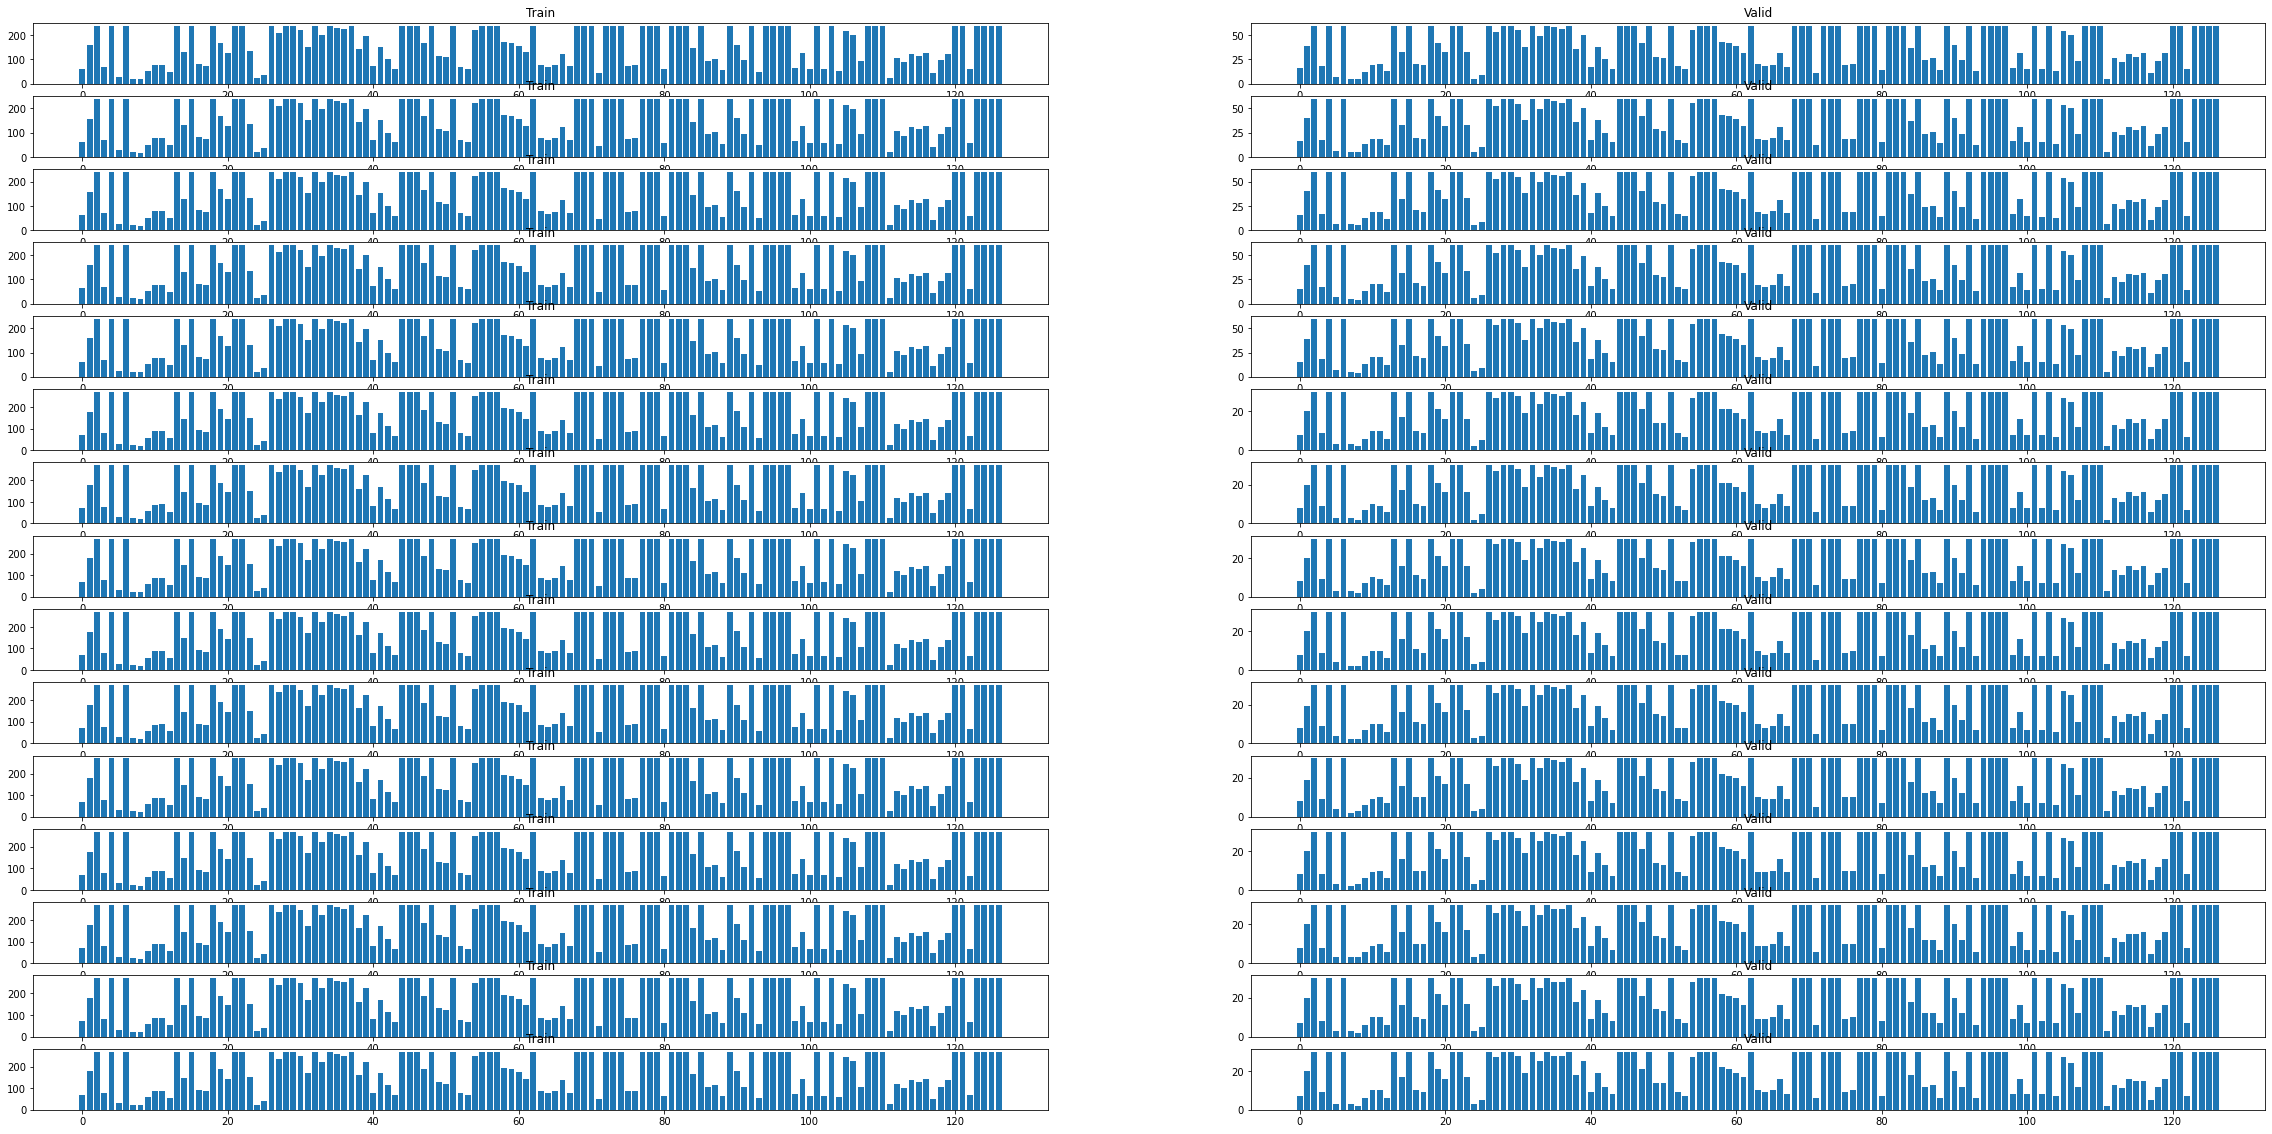

In [35]:
all_dict, count_all_dict = create_all_dict(dataset_path, min_num, max_num)
num_classes = len(all_dict)

train_images, train_labels = create_train_list(dataset_path, all_dict, count_all_dict)

plt.figure(figsize=(40, 20))
# for skf_num in range(3, 11):
kfold = 1
for skf_num in [5, 10]:
    skf = StratifiedKFold(n_splits=skf_num)
    
    
    # train_dict = dict() 
    # valid_dict = dict() 
    for train_idx, valid_idx in skf.split(train_images, train_labels):
        
        train_dict = dict() 
        valid_dict = dict() 
        
        for lbl in train_labels[train_idx]:
            
            if lbl[0] in train_dict:
                train_dict[lbl[0]] += 1 
            else:
                train_dict[lbl[0]] = 1 
                
        train_list = sorted(train_dict.items())
        x, y = zip(*train_list)
        
        plt.subplot(15, 2, kfold)
        plt.title('Train')
        plt.bar(x, y)
        
        kfold += 1
        
        for lbl in train_labels[valid_idx]:
            
            if lbl[0] in valid_dict:
                valid_dict[lbl[0]] += 1 
            else:
                valid_dict[lbl[0]] = 1 
                
        valid_list = sorted(valid_dict.items())
        v_x, v_y = zip(*valid_list)
        
        plt.subplot(15, 2, kfold)
        plt.title('Valid')
        plt.bar(v_x, v_y)
        
        kfold += 1
        print(kfold)
        
plt.show()        

        
        

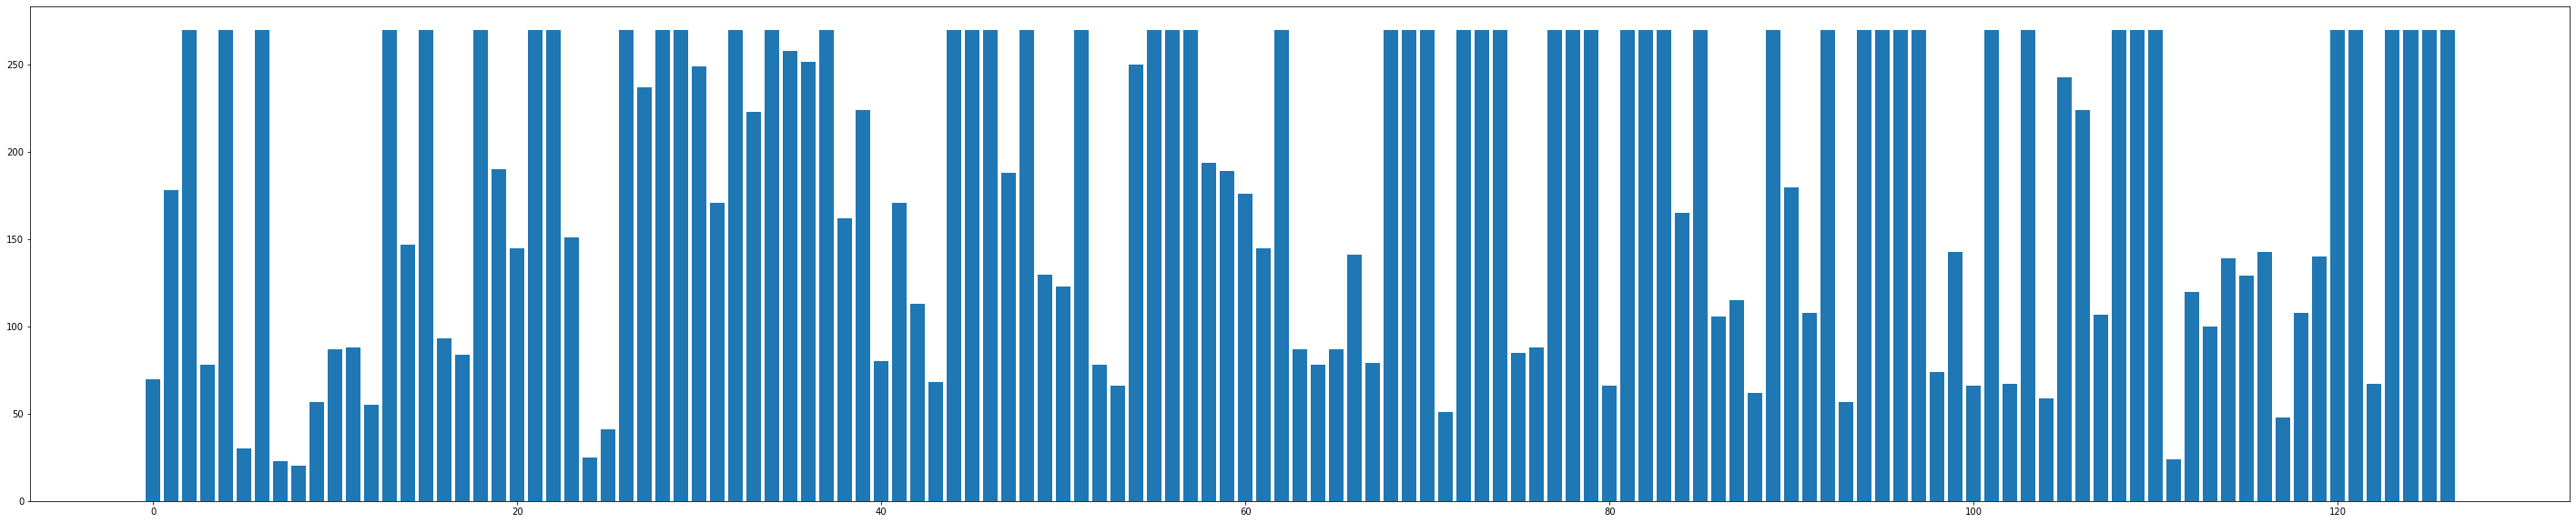

In [23]:
plt.figure(figsize=(50, 10))
plt.bar(x, y) 
plt.show()

In [ ]:
train_dict

In [39]:
all_dict, count_all_dict = create_all_dict(dataset_path, min_num, max_num)
num_classes = len(all_dict)

train_images, train_labels = create_train_list(dataset_path, all_dict, count_all_dict)

# for skf_num in range(3, 11):
for skf_num in [5, 10]:
    skf = StratifiedKFold(n_splits=skf_num)
    
    kfold = 0 
    for train_idx, valid_idx in skf.split(train_images, train_labels):
        
        # strategy = tf.distribute.MirroredStrategy()
        # with strategy.scope():
        with tf.device('/gpu:0'):
            model = create_model('efficient', res=N_RES, num_classes=num_classes, trainable=True, num_trainable=100, mc=False)


        train_dataset = create_dataset(train_images[train_idx], train_labels[train_idx], aug=False) 
        valid_dataset = create_dataset(train_images[valid_idx], train_labels[valid_idx]) 
    
        train_dataset = train_dataset.batch(N_BATCH, drop_remainder=True).shuffle(1000).prefetch(AUTOTUNE)
        valid_dataset = valid_dataset.batch(N_BATCH, drop_remainder=True).shuffle(1000).prefetch(AUTOTUNE)

        sv = [tf.keras.callbacks.ModelCheckpoint(os.path.join(f'../../models/child_skin_classification/checkpoint_{time.strftime("%Y%m%d-%H%M%S")}_efficientb4_kfold_{skf_num}_{kfold}.h5'), 
                                            monitor='val_accuracy', 
                                            verbose=0, 
                                            save_best_only=True,
                                            save_weights_only=False, 
                                            mode='max', 
                                            save_freq='epoch'), 
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                        patience = 4, 
                                        min_delta = 0.01)]

        hist = model.fit(train_dataset,
                validation_data=valid_dataset,
                epochs=50,
                verbose=1,
                callbacks=[sv])

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\ProgramData\Miniconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\Miniconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\Miniconda3\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\ProgramData\Miniconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\Miniconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\ProgramData\Miniconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\ProgramData\Miniconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8076\100889263.py", line 36, in <cell line: 7>
      hist = model.fit(train_dataset,
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1009, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\ProgramData\Miniconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\Miniconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\Miniconda3\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\ProgramData\Miniconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\Miniconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\ProgramData\Miniconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\ProgramData\Miniconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\ProgramData\Miniconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8076\100889263.py", line 36, in <cell line: 7>
      hist = model.fit(train_dataset,
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1009, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  Failed to allocate memory for the batch of component 0
	 [[{{node IteratorGetNext}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[IteratorGetNext/_4]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  Failed to allocate memory for the batch of component 0
	 [[{{node IteratorGetNext}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_90683]